# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
np.random.seed(42) 

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [3]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
print('The sum total of naturally missing values is {}'.format(azdias.isnull().sum().sum()))

The sum total of naturally missing values is 4896838


In [9]:
print('The sum total of naturally missing values is {}'.format(azdias.isnull().sum().sum()))

The sum total of naturally missing values is 4896838


In [10]:
#Code block provided by Zephyr C in Mentor Help, https://knowledge.udacity.com/questions/386302
for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

In [11]:
print('The sum total of missing or unknown values in the dataset is {}'.format(azdias.isnull().sum().sum()-4896838))

The sum total of missing or unknown values in the dataset is 3477091


In [12]:
print('The sum total of all missing/unknown or naturally missing values is {}'.format(azdias.isnull().sum().sum()))

The sum total of all missing/unknown or naturally missing values is 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
missing_data_per_column = pd.isnull(azdias).sum() / len(azdias) * 100
missing_data_per_column.sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

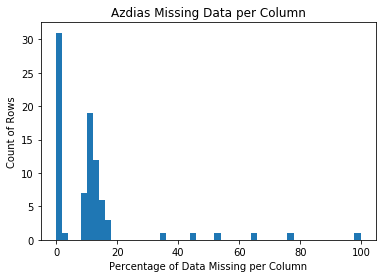

In [14]:
plt.hist(missing_data_per_column, bins= 50);
plt.title('Azdias Missing Data per Column');
plt.xlabel('Percentage of Data Missing per Column');
plt.ylabel('Count of Rows');

In [15]:
missing_data = missing_data_per_column[missing_data_per_column >= 20]

In [16]:
columns_to_drop = missing_data.index.tolist()

In [17]:
print('These are the columns missing 20% or more data that we will be dropping:{}'.format(columns_to_drop))

These are the columns missing 20% or more data that we will be dropping:['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [18]:
azdias.drop(columns=columns_to_drop, inplace = True)

In [19]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.2: Assess Missing Data in Each Column

After assessing how much data was missing from each column, I found 6 columns missing in excess of 34% of their data. The next closest was missing almost 18% of data, this leads me to chooseing 20% missing data as a good cutoff point. Therefor I dropped the 6 columns that were missing more then 20% of their data. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

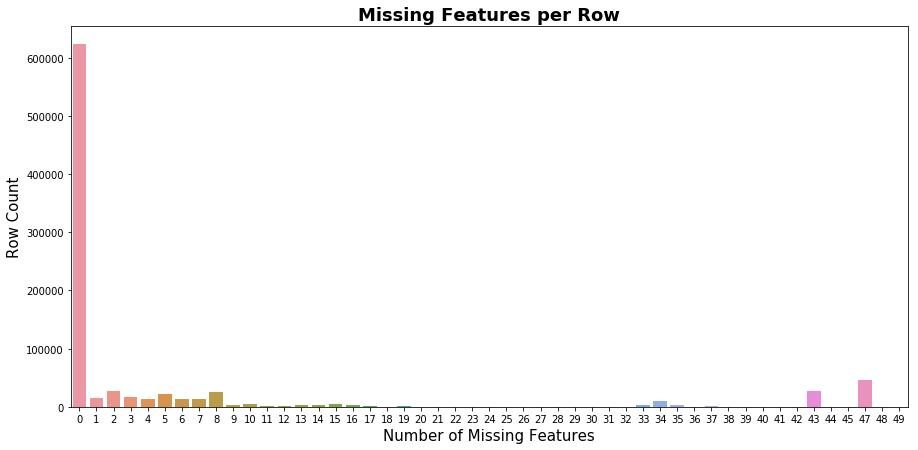

In [20]:
countplt, ax = plt.subplots(figsize = (15,7))
ax =sns.countplot(azdias.isnull().sum(axis = 1))
ax.set_title('Missing Features per Row',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Number of Missing Features', fontsize = 15);
ax.set_ylabel('Row Count', fontsize = 15);

In [21]:
low_missing = azdias[azdias.isnull().sum(axis = 1) <=8]
high_missing = azdias[azdias.isnull().sum(axis = 1) >8]

In [22]:
low_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771701 entries, 1 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     769218 non-null float64
ANREDE_KZ                771701 non-null int64
CJT_GESAMTTYP            771701 non-null float64
FINANZ_MINIMALIST        771701 non-null int64
FINANZ_SPARER            771701 non-null int64
FINANZ_VORSORGER         771701 non-null int64
FINANZ_ANLEGER           771701 non-null int64
FINANZ_UNAUFFAELLIGER    771701 non-null int64
FINANZ_HAUSBAUER         771701 non-null int64
FINANZTYP                771701 non-null int64
GFK_URLAUBERTYP          771701 non-null float64
GREEN_AVANTGARDE         771701 non-null int64
HEALTH_TYP               739213 non-null float64
LP_LEBENSPHASE_FEIN      730996 non-null float64
LP_LEBENSPHASE_GROB      733594 non-null float64
LP_FAMILIE_FEIN          748003 non-null float64
LP_FAMILIE_GROB          748003 non-null float64
LP_STATUS_FEIN           771701 non-null float64
LP_STATUS_GROB           

In [23]:
#Code provided by Jamal H from mentor help, https://knowledge.udacity.com/questions/311016
def compare_distribution(column_name):
    fig = plt.figure(figsize=(13,5))
    axis1 = fig.add_subplot(121)
    axis1.title.set_text('Low Missing Data')
    sns.countplot(azdias.loc[low_missing.index, column_name])
    axis2 = fig.add_subplot(122)
    axis2.title.set_text('High Missing Data')
    sns.countplot(azdias.loc[high_missing.index, column_name])

In [24]:
columns_to_compare = azdias.sample(n=5,axis=1, random_state =42)

In [25]:
column_names = []
for col in columns_to_compare.columns:
    column_names.append(col)

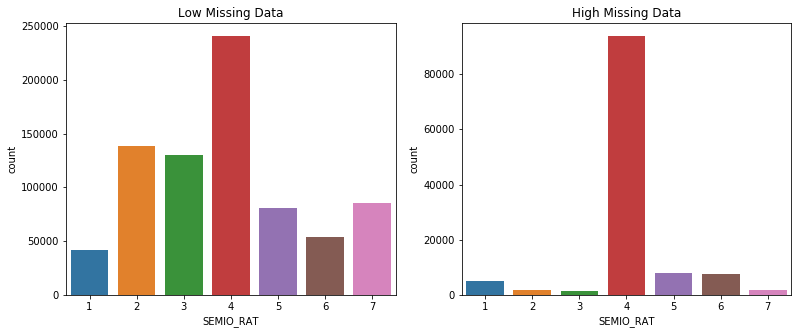

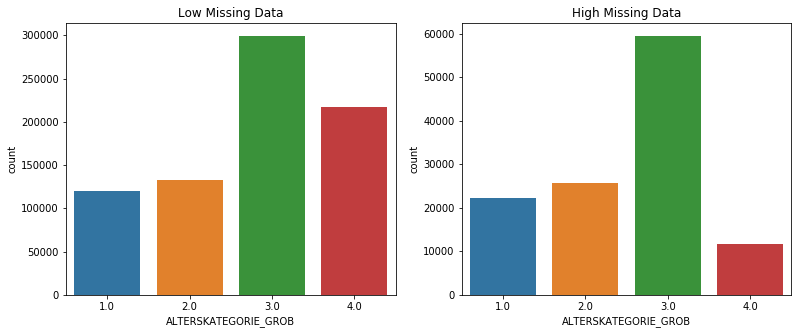

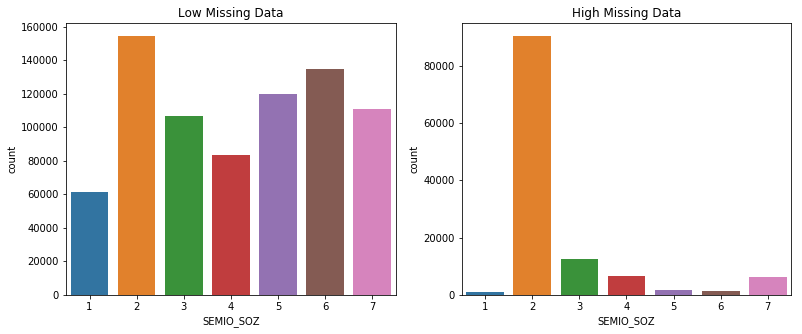

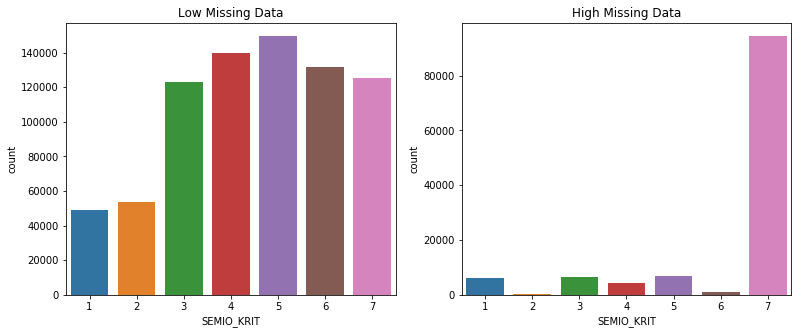

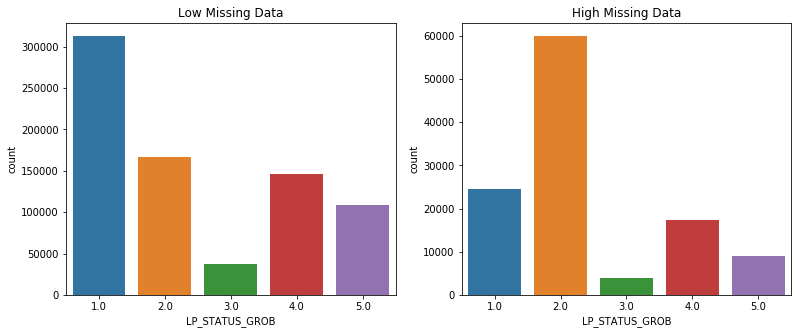

In [26]:
for column_name in column_names:
    compare_distribution(column_name)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Comparing 5 random columns from the subset with 8 or less missing features to the subset with more than 8 missing features we can see that for SEMIO_RAT, SEMIO_SOZ, SEMIO_KRIT, and LP_STATUS_GROB the distribution of data is very different between the 2 data sets. On the other hand for ALTERSKATEGORIE_GROB column, the distribution of data is very similar between the 2 different subsets of data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
#Code provided by Jamal H from mentor help, https://knowledge.udacity.com/questions/327597
#To know and separate which feature is binary and those that are multi-level, you can loop through the cat_features
#and check if the length of a feature in azdias is equal to 2, then it should be binary (save in a list) and if the
#length is greater than 2, it should be saved as a multi-level feature.
cat_features = feat_info[feat_info["type"]=="categorical"]

In [28]:
binary_feat = []
multi_level_feat = []

for feat in list(cat_features['attribute']):
    try:
        if len(low_missing[feat].value_counts()) > 2:
            multi_level_feat.append(feat)
        else:
            binary_feat.append(feat)
    except:
        pass

In [29]:
binary_feat

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

I checked these 5 columns against the data dictionary. OST_WEST_KZ is the non-numerical binary feature and will need re-encoded

### 3.6. OST_WEST_KZ
Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)

In [30]:
#Code provided by Jamal H from mentor help, https://knowledge.udacity.com/questions/307174
new_values = {'W': 0, 'O': 1}
low_missing = low_missing.replace({'OST_WEST_KZ':new_values})

In [31]:
low_missing['OST_WEST_KZ']

1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
12        0
13        0
15        0
16        0
18        0
19        0
21        0
22        0
23        0
25        0
27        0
28        0
29        0
31        0
32        0
33        0
34        0
36        0
37        0
38        0
         ..
891190    0
891191    0
891192    0
891193    0
891194    0
891195    0
891196    0
891197    0
891198    0
891199    0
891200    0
891201    0
891202    0
891204    0
891205    0
891206    0
891207    0
891208    0
891209    0
891210    0
891211    0
891212    0
891213    0
891214    0
891215    0
891216    0
891217    0
891218    0
891219    0
891220    0
Name: OST_WEST_KZ, Length: 771701, dtype: int64

In [32]:
multi_level_feat

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [33]:
azdias_clean = low_missing.drop(multi_level_feat, axis=1)

In [34]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771701 entries, 1 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     769218 non-null float64
ANREDE_KZ                771701 non-null int64
FINANZ_MINIMALIST        771701 non-null int64
FINANZ_SPARER            771701 non-null int64
FINANZ_VORSORGER         771701 non-null int64
FINANZ_ANLEGER           771701 non-null int64
FINANZ_UNAUFFAELLIGER    771701 non-null int64
FINANZ_HAUSBAUER         771701 non-null int64
GREEN_AVANTGARDE         771701 non-null int64
HEALTH_TYP               739213 non-null float64
LP_LEBENSPHASE_FEIN      730996 non-null float64
LP_LEBENSPHASE_GROB      733594 non-null float64
PRAEGENDE_JUGENDJAHRE    747372 non-null float64
RETOURTYP_BK_S           771701 non-null float64
SEMIO_SOZ                771701 non-null int64
SEMIO_FAM                771701 non-null int64
SEMIO_REL                771701 non-null int64
SEMIO_MAT                771701 non-null int64
SEMIO_VERT               771701

#### Discussion 1.2.1: Re-Encode Categorical Features

For binary (two-level) categoricals that take numeric values, I kept them as is.
There is one binary variable that takes on non-numeric values. OST_WEST_KZ used non-numeric values. I used a map to changes these values to 0 and 1 making them numerical.
There were 13 multi level features in this data set, to keep to simplicty I chose to drop these 13 columns from the data set.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [35]:
#pseudo code provided by Deepansh K from mentor help, https://knowledge.udacity.com/questions/192325
def reengineer_movement(x):
    if x is np.nan:
        return np.nan            
    elif x in [1,3,5,8,10,12,14]: 
        return 1
    else:
        return 2

In [36]:
def reengineer_decade(x):
        if x is np.nan:
            return np.nan            
        elif x in [1, 3, 5, 8, 10, 12, 14]: 
            return 1
        else:
            return 2

In [37]:
azdias_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT']= azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(reengineer_movement)

In [38]:
azdias_clean['PRAEGENDE_JUGENDJAHRE_DECADE']= azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(reengineer_decade)

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [39]:
def reengineer_wealth(x):
    if x is np.nan:
        return np.nan            
    elif x in [11, 12, 13, 14, 15]: 
        return 1
    elif x in [21, 22, 23, 24, 25]: 
        return 2
    elif x in [31, 32, 33, 34, 35]:
        return 3
    elif x in [41, 42, 43, 44, 45]:
        return 4 
    else:
        return 5

In [40]:
def reengineer_life_stage(x):
    if x is np.nan:
        return np.nan            
    elif x in [11, 21, 31, 41, 51]:
        return 1
    elif x in [12, 22, 32, 42, 52]:
        return 2
    elif x in [13, 23, 33, 43, 53]:
        return 3
    elif x in [14, 24, 34, 44, 54]:
        return 4
    else:
        return 5

In [41]:
azdias_clean['CAMEO_INTL_2015_WEALTH']= azdias_clean['CAMEO_INTL_2015'].apply(reengineer_wealth)

In [42]:
azdias_clean['CAMEO_INTL_2015_LIFE_STAGE']= azdias_clean['CAMEO_INTL_2015'].apply(reengineer_life_stage)

In [43]:
azdias_clean.drop(columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], inplace=True)

In [44]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771701 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB              769218 non-null float64
ANREDE_KZ                         771701 non-null int64
FINANZ_MINIMALIST                 771701 non-null int64
FINANZ_SPARER                     771701 non-null int64
FINANZ_VORSORGER                  771701 non-null int64
FINANZ_ANLEGER                    771701 non-null int64
FINANZ_UNAUFFAELLIGER             771701 non-null int64
FINANZ_HAUSBAUER                  771701 non-null int64
GREEN_AVANTGARDE                  771701 non-null int64
HEALTH_TYP                        739213 non-null float64
LP_LEBENSPHASE_FEIN               730996 non-null float64
LP_LEBENSPHASE_GROB               733594 non-null float64
RETOURTYP_BK_S                    771701 non-null float64
SEMIO_SOZ                         771701 non-null int64
SEMIO_FAM                         771701 non-null int64
SEMIO_REL                         77170

#### Discussion 1.2.2: Engineer Mixed-Type Features



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
  
    # convert missing value codes into NaNs, ...
    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

        
    # remove selected columns and rows, ...
    # drop columns with more than 20% missing values
    df = df.drop(columns=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'])
    
    # drop rows with more than 10 missing values
    df = df[df.isnull().sum(axis = 1) <=8]

    # Re-encoding char, numeric and non-numeric binary features
    cat_features = feat_info[feat_info["type"]=="categorical"]
    binary_feat = []
    multi_level_feat = []

    for feat in list(cat_features['attribute']):
        try:
            if len(low_missing[feat].value_counts()) > 2:
                multi_level_feat.append(feat)
            else:
                binary_feat.append(feat)
        except:
            pass
    
    new_values = {'W': 0, 'O': 1}
    df = df.replace({'OST_WEST_KZ':new_values})
    
    # drop multi-leve features
    df = df.drop(multi_level_feat, axis=1)
        
    # engineer mixed features
    def reengineer_movement(x):
        if x is np.nan:
            return np.nan            
        elif x in [1,3,5,8,10,12,14]: 
            return 1
        else:
            return 2
    
    
    def reengineer_decade(x):
        if x is np.nan:
            return np.nan            
        elif x in [1, 3, 5, 8, 10, 12, 14]: 
            return 1
        else:
            return 2
        

    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT']= df['PRAEGENDE_JUGENDJAHRE'].apply(reengineer_movement)
    df['PRAEGENDE_JUGENDJAHRE_DECADE']= df['PRAEGENDE_JUGENDJAHRE'].apply(reengineer_decade)
    
    
    def reengineer_wealth(x):
        if x is np.nan:
            return np.nan            
        elif x in [11, 12, 13, 14, 15]: 
            return 1
        elif x in [21, 22, 23, 24, 25]: 
            return 2
        elif x in [31, 32, 33, 34, 35]:
            return 3
        elif x in [41, 42, 43, 44, 45]:
            return 4 
        else:
            return 5
    
    
    def reengineer_life_stage(x):
        if x is np.nan:
            return np.nan            
        elif x in [11, 21, 31, 41, 51]:
            return 1
        elif x in [12, 22, 32, 42, 52]:
            return 2
        elif x in [13, 23, 33, 43, 53]:
            return 3
        elif x in [14, 24, 34, 44, 54]:
            return 4
        else:
            return 5
    
    
    df['CAMEO_INTL_2015_WEALTH']= df['PRAEGENDE_JUGENDJAHRE'].apply(reengineer_wealth)
    df['CAMEO_INTL_2015_LIFE_STAGE']= df['PRAEGENDE_JUGENDJAHRE'].apply(reengineer_life_stage)

    df.drop(columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], inplace=True)

    
    
 
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [46]:
imputer = Imputer(strategy='most_frequent')
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_clean))
azdias_imputed.columns = azdias_clean.columns

In [47]:
azdias_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771701 entries, 0 to 771700
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB              771701 non-null float64
ANREDE_KZ                         771701 non-null float64
FINANZ_MINIMALIST                 771701 non-null float64
FINANZ_SPARER                     771701 non-null float64
FINANZ_VORSORGER                  771701 non-null float64
FINANZ_ANLEGER                    771701 non-null float64
FINANZ_UNAUFFAELLIGER             771701 non-null float64
FINANZ_HAUSBAUER                  771701 non-null float64
GREEN_AVANTGARDE                  771701 non-null float64
HEALTH_TYP                        771701 non-null float64
LP_LEBENSPHASE_FEIN               771701 non-null float64
LP_LEBENSPHASE_GROB               771701 non-null float64
RETOURTYP_BK_S                    771701 non-null float64
SEMIO_SOZ                         771701 non-null float64
SEMIO_FAM                         771701 non-null float64
SEMIO_REL          

In [48]:
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputed)

In [49]:
azdias_scaled = pd.DataFrame(azdias_scaled, columns=azdias_imputed.columns)

In [50]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-1.764603,0.959073,-1.488002,1.539656,-1.043931,1.468403,0.981832,1.326992,-0.531851,1.007628,...,-0.643828,1.435093,0.564057,-0.179612,-0.133963,0.678912,-0.580462,-0.580462,0.0,0.0
1,0.199826,0.959073,-1.488002,0.866704,-1.769993,-0.569520,0.264219,1.326992,1.880228,1.007628,...,-0.643828,0.404593,0.564057,-0.179612,-0.133963,-0.796441,1.722765,1.722765,0.0,0.0
2,1.182040,0.959073,0.690044,-0.479200,1.134255,-0.569520,-1.171006,-0.819321,-0.531851,-0.314912,...,-0.643828,-0.625907,0.564057,-1.183607,-1.004797,-0.058765,-0.580462,-0.580462,0.0,0.0
3,0.199826,-1.042673,0.690044,0.193752,0.408193,-1.248828,0.264219,-0.819321,-0.531851,1.007628,...,0.042626,-0.625907,-0.339213,0.824384,0.301453,1.416588,-0.580462,-0.580462,0.0,0.0
4,-1.764603,0.959073,-0.035971,-1.152152,1.134255,-0.569520,-0.453393,1.326992,-0.531851,1.007628,...,-0.643828,1.435093,1.467327,-1.183607,-1.004797,-0.058765,-0.580462,-0.580462,0.0,0.0


### Discussion 2.1: Apply Feature Scaling

For the above section as it pertains to the missing values in the dataset, I chose to use an imputer to change the missing values to mode to ensure there will be no missing values.

I then used sklearns StandardScaler function to  scale each feature to mean 0 and standard deviation of 1. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [51]:
pca = PCA()
pca_fit = pca.fit_transform(azdias_scaled);

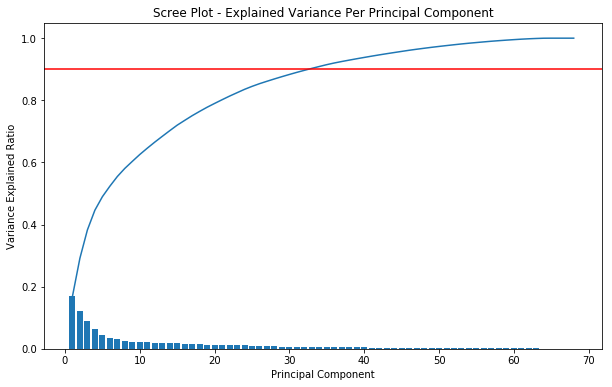

In [52]:
prinicpal_component_values = np.arange(pca.n_components_) + 1
cumulative_prinicpal_component_values = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
ax.bar(prinicpal_component_values, pca.explained_variance_ratio_)
ax.plot(prinicpal_component_values, cumulative_prinicpal_component_values)
plt.title('Scree Plot - Explained Variance Per Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Ratio')
plt.axhline(y=0.9, color = 'r')
plt.show()

In [53]:
pca_reduction = PCA(n_components = 30, random_state =42)
azdias_pca = pca_reduction.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Using the above plots to explain the variance explained ratio per prinicipal component as well as the cumulkative explained variance, we can see that 30 components seems like a good choice for this data set as it covers almost 90% of the variance while only using less than half the total number of components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
def print_feat_weights(pca, component_number):
    feature_df = pd.DataFrame(pca.components_, columns = azdias_scaled.columns)
    weights = feature_df.iloc[component_number]
    sorted = weights.sort_values(ascending=False)
    return sorted

In [55]:
print_feat_weights(pca_reduction, 1)

ALTERSKATEGORIE_GROB              0.277623
SEMIO_ERL                         0.258871
FINANZ_VORSORGER                  0.240519
SEMIO_LUST                        0.192916
RETOURTYP_BK_S                    0.160746
SEMIO_KRIT                        0.138317
SEMIO_KAEM                        0.132755
ANREDE_KZ                         0.116002
W_KEIT_KIND_HH                    0.103012
SEMIO_DOM                         0.091798
FINANZ_HAUSBAUER                  0.091645
FINANZ_MINIMALIST                 0.089154
EWDICHTE                          0.066925
ORTSGR_KLS9                       0.065589
WOHNDAUER_2008                    0.065144
PLZ8_ANTG3                        0.060532
PLZ8_ANTG4                        0.057425
PLZ8_BAUMAX                       0.052791
KBA05_ANTG4                       0.046535
RELAT_AB                          0.045066
ARBEIT                            0.044844
PLZ8_ANTG2                        0.042259
ANZ_HAUSHALTE_AKTIV               0.040235
VERS_TYP   

In [56]:
print_feat_weights(pca_reduction, 2)

SEMIO_VERT                        0.340871
SEMIO_SOZ                         0.252495
SEMIO_FAM                         0.228481
SEMIO_KULT                        0.208119
FINANZ_MINIMALIST                 0.171539
RETOURTYP_BK_S                    0.124243
FINANZ_VORSORGER                  0.120571
ALTERSKATEGORIE_GROB              0.107134
W_KEIT_KIND_HH                    0.086938
SEMIO_LUST                        0.086287
GREEN_AVANTGARDE                  0.075866
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.066984
PRAEGENDE_JUGENDJAHRE_DECADE      0.066984
ORTSGR_KLS9                       0.063183
EWDICHTE                          0.062376
PLZ8_BAUMAX                       0.054509
PLZ8_ANTG4                        0.052955
PLZ8_ANTG3                        0.052823
SEMIO_REL                         0.041790
WOHNDAUER_2008                    0.040928
ARBEIT                            0.039187
RELAT_AB                          0.038282
PLZ8_ANTG2                        0.036267
SEMIO_MAT  

In [57]:
print_feat_weights(pca_reduction, 3)

GREEN_AVANTGARDE                  0.366190
PRAEGENDE_JUGENDJAHRE_DECADE      0.362714
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.362714
EWDICHTE                          0.219766
ORTSGR_KLS9                       0.218456
LP_LEBENSPHASE_FEIN               0.164494
LP_LEBENSPHASE_GROB               0.163035
ANZ_PERSONEN                      0.156793
ONLINE_AFFINITAET                 0.147318
SEMIO_DOM                         0.123155
SEMIO_KAEM                        0.093700
RELAT_AB                          0.092658
PLZ8_HHZ                          0.092438
FINANZ_UNAUFFAELLIGER             0.092413
PLZ8_ANTG2                        0.088470
PLZ8_ANTG3                        0.088078
KBA05_ANTG1                       0.080682
PLZ8_ANTG4                        0.073539
SEMIO_RAT                         0.072058
ANREDE_KZ                         0.062358
ARBEIT                            0.061429
PLZ8_BAUMAX                       0.060688
SEMIO_TRADV                       0.059193
MOBI_REGIO 

### Discussion 2.3: Interpret Principal Components

Component 1:
For component 1 the strongest positive feature is ALTERSKATEGORIE_GROB(0.277623), the strongest negative weighted component is SEMIO_REL(-0.284492). According to the data dictionary ALTERSKATEGORIE_GROB refers to the age range of individuals in this component while SEMIO_REL refers to the religious natrure of the inidivuals in this component. From this we can infer that this component increases with increases to age range and decreases as religious affinity decreases. Additionaly since these components have opposite signs when one goes up the other goes down and vide versa.

Component 2:
For component 2 the strongest positive feature is SEMIO_VERT(0.340871) relates to those with a dreamful personality. While the 2nd strongest positive weighted feature is SEMIO_SOZ(0.252495) indicates those that have a social minded personality. Again with SEMIO_VERT being positive, this means this component will increase with increases to those with a dreamful personality. Additionally this component would decrease as those with social minded personalities decrease.

Component 3:
Component 3's strongest positive weighted feature is GREEN_AVANTGARDE(0.366190) while the strongest negative feature is WOHNLAGE(-0.238730). According to the data dictionary these features correspond to Membership in environmental sustainability as part of youth and Neighborhood quality (or rural flag) respectively. Again as these features are negatively correlated we would except as one goes up the other would go down or vice versa. We would also expect that as membership in environmental sustainability as part of youth increase so would this component as a whole. Alternatively as neighborhood quality decreases we would expect this component to decrease with it.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [85]:
def get_kmeans_scores(data, centroid):
    kmeans = KMeans(n_clusters = centroid, random_state =42)
    model = kmeans.fit(data)
    labels = model.predict(data)
    scores = np.abs(kmeans.score(data))
    return scores

In [86]:
scores = []
centroids = list(range(1,15))
for centroid in centroids:
    scores.append(get_kmeans_scores(azdias_pca, centroid))    

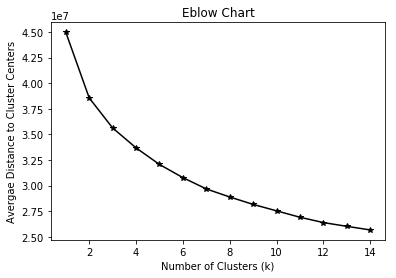

In [87]:
plt.plot(centroids,scores, marker = "*", color = 'k');
plt.ylabel('Avergae Distance to Cluster Centers')
plt.xlabel('Number of Clusters (k)')
plt.title('Eblow Chart');

In [88]:
kmeans_7 = KMeans(n_clusters=7).fit(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

The above plot does not show a pronounced elbow, so in this case we need to use a little more are than science to choose the number of clusters for this dataset. That being said 7 is often a lucky number for some, so we will choose 7 for our number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [65]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [66]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [67]:
customers = clean_data(customers)

In [68]:
azdias_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771701 entries, 0 to 771700
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB              771701 non-null float64
ANREDE_KZ                         771701 non-null float64
FINANZ_MINIMALIST                 771701 non-null float64
FINANZ_SPARER                     771701 non-null float64
FINANZ_VORSORGER                  771701 non-null float64
FINANZ_ANLEGER                    771701 non-null float64
FINANZ_UNAUFFAELLIGER             771701 non-null float64
FINANZ_HAUSBAUER                  771701 non-null float64
GREEN_AVANTGARDE                  771701 non-null float64
HEALTH_TYP                        771701 non-null float64
LP_LEBENSPHASE_FEIN               771701 non-null float64
LP_LEBENSPHASE_GROB               771701 non-null float64
RETOURTYP_BK_S                    771701 non-null float64
SEMIO_SOZ                         771701 non-null float64
SEMIO_FAM                         771701 non-null float64
SEMIO_REL          

In [69]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135799 entries, 0 to 191651
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB              135595 non-null float64
ANREDE_KZ                         135799 non-null int64
FINANZ_MINIMALIST                 135799 non-null int64
FINANZ_SPARER                     135799 non-null int64
FINANZ_VORSORGER                  135799 non-null int64
FINANZ_ANLEGER                    135799 non-null int64
FINANZ_UNAUFFAELLIGER             135799 non-null int64
FINANZ_HAUSBAUER                  135799 non-null int64
GREEN_AVANTGARDE                  135799 non-null int64
HEALTH_TYP                        133866 non-null float64
LP_LEBENSPHASE_FEIN               129746 non-null float64
LP_LEBENSPHASE_GROB               129845 non-null float64
RETOURTYP_BK_S                    135799 non-null float64
SEMIO_SOZ                         135799 non-null int64
SEMIO_FAM                         135799 non-null int64
SEMIO_REL                         13579

In [70]:
# Replace NaN
customers_imputed = pd.DataFrame(imputer.transform(customers))
customers_imputed.columns = customers.columns
#customers_imputed.index = customers.index

In [76]:
cumstomers_scaled = scaler.transform(customers_imputed);

In [77]:
customers_pca = pca_reduction.transform(customers_imputed);

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

### Discussion 3.3: Compare Customer Data to Demographics Data



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.